In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU ac?celerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Dec  9 20:22:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Arthur: Diwen Lu, Email: dl3209@nyu.edu <br>
Remember to change runtime type to GPU

# Mount with GDrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Import Packages for Model Inference

In [2]:
%%capture
# %%capture suppress the output of following !pip as they are tedious
!pip3 install pyyaml==5.1 pycocotools>=2.0.1 ipython
!pip3 install torch torchvision tensorflow 
!python3 -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip3 install Pillow
!pip3 install pandas
!pip3 install scikit-learn funcy
!pip install awscli

# Check if tensorboard is installed, otherwise install it
!if [[ $(pip3 list | grep -c tensorboard) -eq 0 ]]; then pip3 install tensorboard; else echo "tensorboard already installed"; fi

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import copy
import numpy as np
from urllib import request
import pandas as pd
import os, json, shutil, cv2, random, datetime, torch, torchvision
from shutil import copyfile
import PIL
from PIL import Image
from IPython.display import Image as IImage
from IPython.display import display, HTML
from IPython.display import IFrame
import json, funcy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import torchvision.transforms as transforms
import torch

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

import math

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



If the following cell gives any error, please restart runtime, then rerun the last cell (not clear of reason why it behaves such strange)

In [2]:
print(PIL.PILLOW_VERSION)

8.0.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  """Entry point for launching an IPython kernel.


# Import Packages for Deep Taylor Decomposition

In [3]:
!git clone https://github.com/myc159/Deep-Taylor-Decomposition

Cloning into 'Deep-Taylor-Decomposition'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 101 (delta 26), reused 82 (delta 15), pack-reused 0
Receiving objects: 100% (101/101), 1.79 MiB | 1.81 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [4]:
% cd Deep-Taylor-Decomposition/ 
# must go into Deep-Taylor-Decomposition/ so 'from model ... ' in the next cell can be executed

/content/Deep-Taylor-Decomposition


Notice some of the pkgs required for DTD have been imported in Model Inference section

In [5]:
# import argparse
import logging
import logging.handlers
import pdb

from model import *
from model import saliency_mapping as sa_map
from torch.autograd import Variable

from tqdm import tqdm 
from tqdm.auto import tqdm

import torch.nn as nn
from torchvision.utils import save_image
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable

import requests

from sklearn import decomposition
from sklearn.preprocessing import MinMaxScaler

from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 1
# random.seed(seed)
torch.manual_seed(seed)


import torch.nn.functional as F

from collections import OrderedDict
from model.resnet import BasicBlock, Bottleneck

try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [6]:
% cd /content/

/content


The following class is only useful if we want to do Class-wised Deep Taylor Decomposition

In [7]:
class ClassWiseDTD(nn.Module):
    def __init__(self, lowest=0., highest=1.):
        super(ClassWiseDTD, self).__init__()
        self.lowest = lowest
        self.highest = highest

    def forward(self, module_stack, y, class_num, model_archi, class_of_interest):
        """
        For civil role data and from how DTD from https://github.com/myc159/Deep-Taylor-Decomposition is coded up,
        class_of_interest = 0 -> civil_large
        class_of_interest = 1 -> medium
        class_of_interest = 2 -> small
        """

        print(y)
        # R = torch.eye(class_num)[class_of_interest]
        R = torch.zeros(class_num)
        R[class_of_interest] = y[0][class_of_interest]
        print(R)

        for i in range(len(module_stack)):
            module = module_stack.pop()
            if len(module_stack) == 0:
                if isinstance(module, nn.Linear):
                    activation = module.activation
                    R = self.backprop_dense_input(activation, module, R)
                elif isinstance(module, nn.Conv2d):
                    activation = module.activation
                    R = self.backprop_conv_input(activation, module, R)
                else:
                    raise RuntimeError(f'{type(module)} layer is invalid initial layer type')
            elif isinstance(module, BasicBlock):
                R = self.basic_block_R_calculate(module, R)
            elif isinstance(module, Bottleneck):
                R = self.bottleneck_R_calculate(module, R)
            else:
                if isinstance(module, nn.AdaptiveAvgPool2d):
                    if model_archi == 'vgg':
                        R = R.view(R.size(0), -1, 7, 7)
                        continue
                    elif model_archi == 'resnet':
                        R = R.view(R.size(0), R.size(1), 1, 1)
                activation = module.activation
                R = self.R_calculate(activation, module, R)

        return R

    def basic_block_R_calculate(self, basic_block, R):
        if basic_block.downsample is not None:
            identity = basic_block.identity
        else:
            identity = basic_block.conv1.activation
        activation = basic_block.activation
        R0, R1 = self.backprop_skip_connect(activation, identity, R)
        R0 = self.backprop_conv(basic_block.conv2.activation, basic_block.conv2, R0)
        R0 = self.backprop_conv(basic_block.conv1.activation, basic_block.conv1, R0)
        if basic_block.downsample is not None:
            for i in range(len(basic_block.downsample)-1, -1, -1):
                R1 = self.R_calculate(basic_block.downsample[i].activation,
                                      basic_block.downsample[i], R1)
        else:
            pass
        R = self.backprop_divide(R0, R1)

        return R

    def bottleneck_R_calculate(self, bottleneck, R):
        if bottleneck.downsample is not None:
            identity = bottleneck.identity
        else:
            identity = bottleneck.conv1.activation
        activation = bottleneck.activation
        R0, R1 = self.backprop_skip_connect(activation, identity, R)
        R0 = self.backprop_conv(bottleneck.conv3.activation, bottleneck.conv3, R0)
        R0 = self.backprop_conv(bottleneck.conv2.activation, bottleneck.conv2, R0)
        R0 = self.backprop_conv(bottleneck.conv1.activation, bottleneck.conv1, R0)
        if bottleneck.downsample is not None:
            for i in range(len(bottleneck.downsample)-1, -1, -1):
                R1 = self.R_calculate(bottleneck.downsample[i].activation,
                                      bottleneck.downsample[i], R1)
        else:
            pass
        R = self.backprop_divide(R0, R1)

        return R

    def R_calculate(self, activation, module, R):
        if isinstance(module, nn.Linear):
            R = self.backprop_dense(activation, module, R)
            return R
        elif isinstance(module, nn.Conv2d):
            R = self.backprop_conv(activation, module, R)
            return R
        elif isinstance(module, nn.BatchNorm2d):
            R = self.backprop_bn(R)
            return R
        elif isinstance(module, nn.ReLU):
            R = self.backprop_relu(activation, R)
            return R
        elif isinstance(module, nn.MaxPool2d):
            R = self.backprop_max_pool(activation, module, R)
            return R
        elif isinstance(module, nn.AdaptiveAvgPool2d):
            R = self.backprop_adap_avg_pool(activation, R)
            return R
        elif isinstance(module, nn.Dropout):
            R = self.backprop_dropout(R)
            return R
        else:
            raise RuntimeError(f"{type(module)} can not handled currently")

    def backprop_dense(self, activation, module, R):
        W = torch.clamp(module.weight, min=0)
        Z = torch.mm(activation, torch.transpose(W, 0, 1)) + 1e-9
        S = R / Z
        C = torch.mm(S, W)
        R = activation * C

        return R

    def backprop_dense_input(self, activation, module, R):
        W_L = torch.clamp(module.weight, min=0)
        W_H = torch.clamp(module.weight, max=0)

        L = torch.ones_like(activation, dtype=activation.dtype) * self.lowest
        H = torch.ones_like(activation, dtype=activation.dtype) * self.highest

        Z_O = torch.mm(activation, torch.transpose(module.weight, 0, 1))
        Z_L = torch.mm(activation, torch.transpose(W_L, 0, 1))
        Z_H = torch.mm(activation, torch.transpose(W_H, 0, 1))

        Z = Z_O - Z_L - Z_H + 1e-9
        S = R / Z

        C_O = torch.mm(S, module.weight)
        C_L = torch.mm(S, W_L)
        C_H = torch.mm(S, W_H)

        R = activation * C_O - L * C_L - H * C_H

        return R

    def backprop_conv(self, activation, module, R):
        stride, padding, kernel = module.stride, module.padding, module.kernel_size
        output_padding = activation.size(2) - ((R.size(2) - 1) * stride[0] \
                                        - 2 * padding[0] + kernel[0])
        W = torch.clamp(module.weight, min=0)
        Z = F.conv2d(activation, W, stride=stride, padding=padding) + 1e-9
        S = R / Z
        C = F.conv_transpose2d(S, W, stride=stride, padding=padding, output_padding=output_padding)
        R = activation * C

        return R

    def backprop_conv_input(self, activation, module, R):
        stride, padding, kernel = module.stride, module.padding, module.kernel_size
        output_padding = activation.size(2) - ((R.size(2) - 1) * stride[0] \
                                                - 2 * padding[0] + kernel[0])

        W_L = torch.clamp(module.weight, min=0)
        W_H = torch.clamp(module.weight, max=0)

        L = torch.ones_like(activation, dtype=activation.dtype) * self.lowest
        H = torch.ones_like(activation, dtype=activation.dtype) * self.highest

        Z_O = F.conv2d(activation, module.weight, stride=stride, padding=padding)
        Z_L = F.conv2d(L, W_L, stride=stride, padding=padding)
        Z_H = F.conv2d(H, W_H, stride=stride, padding=padding)

        Z = Z_O - Z_L - Z_H + 1e-9
        S = R / Z

        C_O = F.conv_transpose2d(S, module.weight, stride=stride, padding=padding, output_padding=output_padding)
        C_L = F.conv_transpose2d(S, W_L, stride=stride, padding=padding, output_padding=output_padding)
        C_H = F.conv_transpose2d(S, W_H, stride=stride, padding=padding, output_padding=output_padding)

        R = activation * C_O - L * C_L - H * C_H

        return R

    def backprop_bn(self, R):
        return R

    def backprop_dropout(self, R):
        return R

    def backprop_relu(self, activation, R):
        return R

    def backprop_adap_avg_pool(self, activation, R):
        kernel_size = activation.shape[-2:]
        Z = F.avg_pool2d(activation, kernel_size=kernel_size) * kernel_size[0] ** 2 + 1e-9
        S = R / Z
        R = activation * S

        return R

    def backprop_max_pool(sef, activation, module, R):
        kernel_size, stride, padding = module.kernel_size, module.stride, module.padding
        Z, indices = F.max_pool2d(activation, kernel_size=kernel_size, stride=stride, \
                                  padding=padding, return_indices=True)
        Z = Z + 1e-9
        S = R / Z
        C = F.max_unpool2d(S, indices, kernel_size=kernel_size, stride=stride, \
                            padding=padding, output_size=activation.shape)
        R = activation * C

        return R

    def backprop_divide(self, R0, R1):
        return R0 + R1

    def backprop_skip_connect(self, activation0, activation1, R):
        Z = activation0 + activation1 + 1e-9
        S = R / Z
        R0 = activation0 * S
        R1 = activation1 * S

        return (R0, R1)


# Register Civil Role Dataset
In this section, we separate the civil role planes from all role-related images. (The pretrained model on role provided in RarePlanes repo only included 3 civil ones and 1 'other' class, so in total 4 categories for classification) We will do the followings:
1. load role data
2. filter out only civil planes
3. create civil role coco json file
4. create a new image dir which contains only civil role images.
5. In the end, we will use 3. and 4. to register civil role planes. 

## Load Role data

In [8]:
real_test_role_coco_dir = "/content/gdrive/MyDrive/RarePlanes/datasets/real/test/role_real_coco.json" # json file containing coco annotation for all role images in testing set
real_imgs_dir = "/content/gdrive/MyDrive/RarePlanes/datasets/real/test/PS-RGB_tiled/" # image directory containing all role images

# real_json_dir = real_test_role_coco_dir
with open(real_test_role_coco_dir) as json_file:
    real_test_role_coco = json.load(json_file)
    
print(real_test_role_coco.keys())
print("Num images in real role test         : {}".format(len(real_test_role_coco['images'])))
print("Num classes in real role test        : {}".format(len(real_test_role_coco['categories'])))
print("Num bbox/instances in real role test : {}".format(len(real_test_role_coco['annotations'])))

dict_keys(['annotations', 'categories', 'images'])
Num images in real role test         : 2710
Num classes in real role test        : 7
Num bbox/instances in real role test : 6812


In [9]:
# merge images with annotations to get image dir
img_list_real = pd.DataFrame(real_test_role_coco['images'])
annotations_real = pd.DataFrame(real_test_role_coco['annotations'])
ann_real = annotations_real.merge(img_list_real, how='left', left_on="image_id", right_on="id").drop(columns = 'id_x')
ann_real.head() # (6812 , 10)

,image_id,category_id,segmentation,area,bbox,iscrowd,id_y,file_name,width,height
0,133,1,"[[80.77480098977685, 363.0152489040047, 178.79...",7827.238176,"[80.77480098977685, 315.1959627214819, 161.849...",0,133,77_104001004299B200_tile_623.png,512,512
1,1318,1,"[[166.936536276713, 420.14599355868995, 231.16...",5570.290015,"[166.936536276713, 371.9716466348618, 120.7278...",0,1318,55_1040010049CD5600_tile_427.png,512,512
2,2272,3,"[[90.58066527545452, 229.61171030439436, 66.55...",7050.829728,"[66.55990155041218, 165.5543037634343, 115.726...",0,2272,67_104001003F0B3200_tile_1359.png,512,512
3,60,1,"[[469.67289331555367, 328.47771842591465, 401....",3009.191438,"[362.94985254481435, 289.4156904295087, 106.72...",0,60,130_10400100452B0100_tile_1157.png,512,512
4,2583,0,"[[106.11534430459142, 423.7973632980138, 92.12...",637.413326,"[70.60971384495497, 404.16483821813017, 35.505...",0,2583,113_104001003D8DB300_tile_35.png,512,512


## Filter out only civil planes

In [10]:
print("keep only the civil category planes, left with {} instances".format(ann_real[ann_real["category_id"] <=2].shape[0]))
civil_images_list = list(ann_real[ann_real["category_id"] <=2].file_name.unique())
print("keeping only {} images".format(len(civil_images_list)))

keep only the civil category planes, left with 6457 instances
keeping only 2601 images


## Create civil role coco json file

In [11]:
real_test_role_coco_dir = "/content/gdrive/MyDrive/RarePlanes/datasets/real/test/role_real_coco.json"
with open(real_test_role_coco_dir) as json_file:
    real_test_role_coco = json.load(json_file)

civil_test_coco = {}
civil_test_coco['annotations'] = [ann for ann in real_test_role_coco['annotations'] if ann['category_id'] <= 2]
civil_test_image_ids = [ann['image_id'] for ann in real_test_role_coco['annotations'] if ann['category_id'] <= 2]
civil_test_coco['images'] = [image for image in real_test_role_coco['images'] if image['id'] in civil_test_image_ids]
civil_test_coco['categories'] = [{'id': 0, 'name': "civil_small"}, {'id': 1, 'name': "civil_medium"}, {'id': 2, 'name': "civil_large"}]


In [12]:
civil_role_dir = "/content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/"
if not os.path.exists(civil_role_dir):
    os.makedirs(civil_role_dir)

# need to save civil_test_coco
civil_role_real_test_coco_path = civil_role_dir + "civil_role_real_coco.json"
with open(civil_role_real_test_coco_path, 'w') as outfile:
    json.dump(civil_test_coco, outfile)

Create new image dir for civil role only

In [13]:
#takes around 20 min to finish
if not os.path.exists(civil_role_dir + 'image'):
    for f in tqdm(civil_images_list):
      copyfile(real_imgs_dir + f, civil_role_dir)

In [14]:
# make sure there ae 2601 images in civil_test/image/
!ls /content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/image | wc -l

2601


Register test datasets

In [15]:
civil_role_real_test_coco_path = "/content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/civil_role_real_coco.json"
civil_role_real_test_images_path = "/content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/image/"

# we only register test data here, as model is pretrained
register_coco_instances("civil_test", {}, civil_role_real_test_coco_path, civil_role_real_test_images_path)

# Generate metadata
satrgb_metadata = MetadataCatalog.get("civil_test")
print(satrgb_metadata)

# Get test dataset catalogs
test_dicts = DatasetCatalog.get("civil_test")

Metadata(evaluator_type='coco', image_root='/content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/image/', json_file='/content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/civil_role_real_coco.json', name='civil_test')
WARNING [12/14 20:49:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/14 20:49:12 d2.data.datasets.coco]: Loaded 2601 images in COCO format from /content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/civil_role_real_coco.json


In [16]:
test_json_dir = civil_role_real_test_coco_path
print("test json loc:", civil_role_real_test_coco_path)
with open(test_json_dir) as json_file:
    civil_role_real_test_coco = json.load(json_file)
    
print(civil_role_real_test_coco.keys())
print("Num images in civil role real test         : {}".format(len(civil_role_real_test_coco['images'])))
print("classes in civil role real test        : {}".format(civil_role_real_test_coco['categories']))
print("Num bbox/instances in civil role real test : {}".format(len(civil_role_real_test_coco['annotations'])))

test json loc: /content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/civil_role_real_coco.json
dict_keys(['annotations', 'images', 'categories'])
Num images in civil role real test         : 2601
classes in civil role real test        : [{'id': 0, 'name': 'civil_small'}, {'id': 1, 'name': 'civil_medium'}, {'id': 2, 'name': 'civil_large'}]
Num bbox/instances in civil role real test : 6457


In [17]:
# role model, faster - rcnn
role_model_dir = "/content/gdrive/MyDrive/RarePlanes/models/model_0023999.pth"
role_model_pth = torch.load(role_model_dir)
print(role_model_pth['model']["roi_heads.box_predictor.cls_score.weight"].shape)
print(role_model_pth['model']["roi_heads.box_predictor.bbox_pred.weight"].shape)

# aircraft model, faster - rcnn
af_model_dir = "/content/gdrive/MyDrive/RarePlanes/models/model_0043999.pth"
af_model_pth = torch.load(af_model_dir)
print(af_model_pth['model']["roi_heads.box_predictor.cls_score.weight"].shape)
print(af_model_pth['model']["roi_heads.box_predictor.bbox_pred.weight"].shape)

torch.Size([4, 1024])
torch.Size([12, 1024])
torch.Size([2, 1024])
torch.Size([4, 1024])


In [18]:
torch.cuda.is_available()

True

# Load Pretrained Faster-RCNN

In [19]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for bbox predication
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
# cfg.MODEL.WEIGHTS = "/content/gdrive/MyDrive/RarePlanes/models/model_0043999.pth" # faster rcnn for aircraft binary classification
cfg.MODEL.WEIGHTS = "/content/gdrive/MyDrive/RarePlanes/models/model_0023999.pth" # faster rcnn for civil role classification
cfg.DATASETS.TEST = ("civil_test", )
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 1 class for aircraft, 3 for civil role
predictor = DefaultPredictor(cfg)
fast_rcnn_model = build_model(cfg)

# Run Pretraind Faster-RCC on Civil Role test
Get bbox and category_id for each detected instances for each test image

In [20]:
def crop_image(file_chosen, bbox):
    dir = "/content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/image/"
    ori_img_dir = dir + file_chosen + '.png'
    my_image = cv2.imread(ori_img_dir)
    buffer=0
    cropped_im = my_image[math.floor(bbox[1]) - buffer : math.ceil(bbox[3]) + buffer,
                          math.floor(bbox[0]) - buffer : math.ceil(bbox[2]) + buffer,:]
    return cropped_im

In [21]:
# takes around 20 minutes to finish
if not os.path.exists('/content/gdrive/MyDrive/cropped_civil_role_images/'):
    os.makedirs('/content/gdrive/MyDrive/cropped_civil_role_images/')
    os.makedirs('/content/gdrive/MyDrive/cropped_civil_role_images/predicted_civil_small')
    os.makedirs('/content/gdrive/MyDrive/cropped_civil_role_images/predicted_civil_medium')
    os.makedirs('/content/gdrive/MyDrive/cropped_civil_role_images/predicted_civil_large')

    cropped_file_names = []
    cropped_file_category = []
    cropped_file_bboxes = []

    category_id2name = {0: 'civil_small', 1: 'civil_medium', 2: 'civil_large'}

    for image in tqdm(civil_role_real_test_coco['images']):
        image_file_name = image['file_name'].split('.')[0]
        image_id = image['id']

        img = cv2.imread(civil_role_real_test_images_path + image_file_name + '.png')
        outputs = predictor(img)

        pred_boxes = outputs['instances'].to('cpu').get_fields()['pred_boxes'].tensor.numpy().tolist()
        pred_classes = outputs['instances'].to('cpu').get_fields()['pred_classes'].numpy().tolist()

        for j, bbox in enumerate(pred_boxes):

            cropped_instance = crop_image(image_file_name, bbox)
            cropped_instance_path = f'/content/gdrive/MyDrive/cropped_civil_role_images/predicted_{category_id2name[pred_classes[j]]}/{image_file_name}_{j+1}th.png'
            cv2.imwrite(cropped_instance_path, cropped_instance)

            cropped_file_names.append(f'{image_file_name}_{j+1}th')
            cropped_file_category.append(pred_classes[j]) 
            cropped_file_bboxes.append(bbox)

In [22]:
if os.path.exists("/content/gdrive/MyDrive/cropped_civil_role_images/instances_prediction_info.csv"):
    prediction_dict_df = pd.read_csv("/content/gdrive/MyDrive/cropped_civil_role_images/instances_prediction_info.csv")
else:
    prediction_dict = {'instance_file_name': cropped_file_names, 'bbox': cropped_file_bboxes , 'category': cropped_file_category}
    prediction_dict_df = pd.DataFrame(prediction_dict)
    prediction_dict_df.to_csv("/content/gdrive/MyDrive/cropped_civil_role_images/instances_prediction_info.csv", index=False)

In [23]:
prediction_dict_df.head(3)

,instance_file_name,bbox,category
0,124_104001001F2A5700_tile_126_1th,"[408.96087646484375, 0.0, 426.7137145996094, 1...",0
1,124_104001001F2A5700_tile_126_2th,"[199.8337860107422, 18.11140251159668, 222.423...",0
2,124_104001001F2A5700_tile_126_3th,"[365.6706848144531, 0.2007037252187729, 404.21...",1


# Train ResNet 50 on predicted instances
Use predicted bbox and category_id from faster_cnn_model to finetune a ResNet50, because third-party DTD code only supports ResNet and ResNet is a backbone in Faster-RCNN. Extract the counterpart layers of ResNet from Faster-RCNN and load them into ResNet. Freeze these layers and only finetune the weights for last FC layer, because our ResNet50 only has 3 classes, not like 1000 classes from ImageNet

In [24]:
resnet_model = resnet50(pretrained=False, num_classes=3)

In [25]:
# load pretrained faster_rcnn for weights extraction
faster_rcnn = torch.load("/content/gdrive/MyDrive/RarePlanes/models/model_0023999.pth")

# download pretrained resnet50 .pth
if not os.path.exists("/content/gdrive/MyDrive/RarePlanes/models/pretrain_res50.pth"):
    data = request.urlopen('https://download.pytorch.org/models/resnet50-19c8e357.pth', timeout=15).read()
    with open("/content/gdrive/MyDrive/RarePlanes/models/pretrain_res50.pth", 'wb') as f:
        f.write(data)

res50 = torch.load("/content/gdrive/MyDrive/RarePlanes/models/pretrain_res50.pth")

In [26]:
#modify the last FC layer shapes to cater for our 3 classes
res50['fc.weight'] = res50['fc.weight'][:3]
res50['fc.bias'] = res50['fc.bias'][:3]
print(res50['fc.weight'].shape)
res50['fc.bias'].shape

torch.Size([3, 2048])


torch.Size([3])

In [27]:
def matching_fpn2res(faster_rnn, res50):
    fas2res = {"res2":"layer1", "res3":"layer2", "res4":"layer3", "res5":"layer4"}
    frcnn_dict = defaultdict(list)
    res50_dict = defaultdict(list)

    for fas_layer_i in fas2res:
        for k in faster_rnn["model"]:
          if fas_layer_i in k and "weight" in k and "shortcut" not in k:
            frcnn_dict[fas_layer_i].append(k)
        for k in res50.keys():
          res_layer_i = fas2res[fas_layer_i]
          if "weight" in k and res_layer_i in k and "down" not in k:
            res50_dict[res_layer_i].append(k)

    return frcnn_dict, res50_dict


def flatten_dict(dic):
    lst = []
    for k,v in dic.items():
        lst+=v
    return lst


def fpn2res_mapping(fas_lst, res50_lst):
    map = {}
    for i,k in enumerate(res50_lst):
        map[fas_lst[i]] = k
    return map

# make model pth mapping
frcnn_dict, res50_dict = matching_fpn2res(faster_rcnn, res50)
fas_lst = flatten_dict(frcnn_dict)
res50_lst = flatten_dict(res50_dict)
mapping = fpn2res_mapping(fas_lst, res50_lst)

res50_by_fpn = res50
for k in mapping:
    res50_by_fpn[mapping[k]] = faster_rcnn["model"][k]
  
# load our resnet_model with extracted weights from pretrained faster-rcnn
resnet_model.load_state_dict(res50_by_fpn)

<All keys matched successfully>

In [28]:
# freeze all but last 2 params of ResNet50
for i, param in enumerate(resnet_model.parameters()):
    param.requires_grad = True if i in [159,160] else False

In [29]:
def our_train(model, train_loader, epoch, num_epoch, learning_rate, weight_decay, log_interval):
    # Using sum reduction simply bc otherwise, the scale of the loss is too small;
    # given that we always have 28*28 images, using sum/mean reduction wouldn't
    # make a difference.
    criteria = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    total_loss = 0
    for i, data in enumerate(train_loader):
        images, targets = data

        targets -= 1

        # send to device
        if torch.cuda.is_available():
            images = images.to(dev)
            targets = targets.to(dev)
        
        # zero grad
        optimizer.zero_grad()
        # feed forward
        outputs = model(images)

        # compute loss
        # for denoising version, loss is between dirty images output and clean input!
        loss = criteria(outputs, targets)
        total_loss += loss.item()

        # backpropogate
        loss.backward()
        optimizer.step()

        if (i + 1) % log_interval == 0:
            print('Epoch [{}/{}] - Iter[{}/{}], Cross Entropy loss:{:.6f}'.format(
                epoch + 1, num_epoch, i + 1,
                len(train_loader.dataset) // batch_size, loss.item() / batch_size
            ))

def validate(model, valid_loader, best_val_loss):
    total_loss = 0
    criteria = nn.CrossEntropyLoss(reduction='sum')
    model.eval()
    for i, data in enumerate(valid_loader):
        images, targets = data
        targets -= 1

        if torch.cuda.is_available():
            images = images.to(dev)
            targets = targets.to(dev)

        outputs = model(images)
        loss = criteria(outputs, targets)
        total_loss += loss
    
    avg_loss = total_loss / (len(valid_loader) * batch_size)

    print('\nLoss per batch on validation set: {:.6f}'.format(avg_loss))

    if avg_loss < best_val_loss:
        save_path = '/content/gdrive/MyDrive/cropped_civil_role_images/'
        best_val_loss = avg_loss
        # Save best model
        torch.save(model.state_dict(), save_path+"/model_"+str(best_val_loss))
        print('Saved best model in the checkpoint directory\n')
    
    return best_val_loss

def predict(model, train_loader):

    if torch.cuda.is_available():
        model = model.to(device)
    model.eval()

    correct = 0
    total = 0
    for i, data in tqdm(enumerate(train_loader)):

        # if i % 500 == 0:
        print(f'batch : {i + 1}')

        images, targets = data
        targets -= 1

        if torch.cuda.is_available():
            images = images.to(device)
            targets = targets.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, axis = 1)

        # print(outputs)
        # print(preds)

        correct += (targets == preds).sum().item()
        total += targets.size(0)
    
    print('Accuracy : %d %%' % (100 * correct / total))

## Acc of un-finetined resnet50 (35%)

In [ ]:
# acc of un-finetined resnet50
train_dir = "/content/gdrive/MyDrive/cropped_civil_role_images/"
batch_size = 1
num_workers = 4

train_dataset = datasets.ImageFolder(
                                      train_dir,
                                      transforms.Compose([
                                          transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                      ]))
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          num_workers=num_workers, pin_memory=True, shuffle=True,
                          drop_last=False)

predict(resnet_model, train_loader)

KeyboardInterrupt: ignored

## Loaded finetuned resnet50

In [31]:
# finetuned model is at /content/gdrive/MyDrive/cropped_civil_role_images/model_tensor(0.5336, device='cuda:0', grad_fn=<DivBackward0>)
resnet_model.load_state_dict(torch.load("/content/gdrive/MyDrive/cropped_civil_role_images/model_tensor(0.5336, device='cuda:0', grad_fn=<DivBackward0>)"))

<All keys matched successfully>

## Acc of finetined resnet50 (75%)

In [ ]:
train_dir = "/content/gdrive/MyDrive/cropped_civil_role_images/"
batch_size = 256
num_workers = 1

train_dataset = datasets.ImageFolder(
                                      train_dir,
                                      transforms.Compose([
                                          transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                      ]))
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          num_workers=num_workers, pin_memory=True, shuffle=True,
                          drop_last=False)

# predict(resnet_model, train_loader)

In [ ]:
# train_loader.dataset.samples

In [ ]:
# If want to further finetune resnet_model, de-comment this cell block
best_val_loss = float('inf')
num_epoch = 50
learning_rate = 1e-3
weight_decay = 0
log_interval = 10

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

# device = torch.device(dev)  

resnet_model = resnet_model.to(dev)

for epoch in range(num_epoch):
    start_time = datetime.datetime.now()
    our_train(resnet_model, train_loader, epoch, num_epoch, learning_rate, weight_decay, log_interval)
    end_time = datetime.datetime.now()
    print(f'Training this epoch using {(end_time - start_time).seconds} seconds')
    # validate and save model if it's the best model so far
    best_val_loss = validate(resnet_model, train_loader, best_val_loss)
print('Training done; best validation loss {:.4f}'.format(best_val_loss))

enter our_train() ...
model train start
ludi
Epoch [1/50] - Iter[10/30], Cross Entropy loss:0.624208
Epoch [1/50] - Iter[20/30], Cross Entropy loss:0.520770
Epoch [1/50] - Iter[30/30], Cross Entropy loss:0.634538
Training this epoch using 26 seconds

Loss per batch on validation set: 0.579386
Saved best model in the checkpoint directory

enter our_train() ...
model train start
ludi
Epoch [2/50] - Iter[10/30], Cross Entropy loss:0.603385
Epoch [2/50] - Iter[20/30], Cross Entropy loss:0.654004
Epoch [2/50] - Iter[30/30], Cross Entropy loss:0.653909
Training this epoch using 27 seconds

Loss per batch on validation set: 0.600981
enter our_train() ...
model train start
ludi
Epoch [3/50] - Iter[10/30], Cross Entropy loss:0.895154
Epoch [3/50] - Iter[20/30], Cross Entropy loss:1.057804
Epoch [3/50] - Iter[30/30], Cross Entropy loss:0.755861
Training this epoch using 26 seconds

Loss per batch on validation set: 0.588719
enter our_train() ...
model train start
ludi
Epoch [4/50] - Iter[10/30],

In [ ]:
# remember to reload the best mode after finetuning
resnet_model.load_state_dict(torch.load("/content/gdrive/MyDrive/cropped_civil_role_images/model_tensor(0.5336, device='cuda:0', grad_fn=<DivBackward0>)"))

<All keys matched successfully>

# Interactive Inference + DTD

some examples classifications

In [ ]:
# these are hand labelled
small2small = ['96_104001003C8C7800_tile_1407',
               '81_1040010032B86F00_tile_373',
               '96_104001003C8C7800_tile_776',
               '67_1040010048B5A300_tile_1398',
               '96_104001003C8C7800_tile_1266', # GOOD
               ]

small2medium = ['84_1040010006ABC200_tile_157',
                '5_104001000156CC00_tile_245',
                '96_104001003C8C7800_tile_1022',
                '81_104001003AD0B700_tile_176',
                '127_104001002B3BB400_tile_744',
                '108_10400100457A8A00_tile_58',
                '61_104001002F594F00_tile_64',
                ]

medium2medium = ['130_10400100452B0100_tile_1352', 
                 '126_104001000C4AEE00_tile_788', 
                 '93_1040010048202D00_tile_1301', 
                 '93_104001002A4FAA00_tile_1272',
                 '84_1040010006ABC200_tile_157',
                 '127_104001002B3BB400_tile_339',
                 '93_104001000493AA00_tile_1495',
                 '67_104001003F0B3200_tile_450',
                 '127_104001002B3BB400_tile_744',
                 '55_1040010049CD5600_tile_437',
                 '93_104001000493AA00_tile_1371',
                 '2_1040010026D45500_tile_22',
                 '118_10400100213D3100_tile_493',
                 '67_1040010046D15B00_tile_1584',
                 '77_1040010040119E00_tile_1002',
                 '77_104001004299B200_tile_1264', # 2 instances
                 '67_1040010048B5A300_tile_745', # 1 instance, a good one
                 ]

medium2large = ['69_104005000CDBE200_tile_1772', 
                '130_10400100452B0100_tile_1436', 
                '130_10400100452B0100_tile_1109', 
                '26_104001001CD3B900_tile_1524', 
                '26_104001001CD3B900_tile_1401',
                '77_104001004299B200_tile_932',
                '77_1040010043B0F100_tile_486',
                '77_104001004299B200_tile_489',
                '126_104001000C4AEE00_tile_1637',
                '77_104001004299B200_tile_1023',
                '26_1040010011C6F000_tile_1711',
                '77_1040010040119E00_tile_511',
                '77_1040010043B0F100_tile_556', 
                '69_104005000CDBE200_tile_2507',
                '69_104005000CDBE200_tile_2889',
                '93_104001000493AA00_tile_1414',
                '128_1040010032BA9100_tile_1789',
                '77_104001004299B200_tile_626',
                '77_104001004299B200_tile_559',
                '31_10400100443CFD00_tile_814',
                '126_104001000C4AEE00_tile_2028' # only 1 major instance
                '77_104001004299B200_tile_798' # a good one
                '11_1040010016C34900_tile_304', # only 1 instance, a good one
                ]

large2large = ['69_104005000CDBE200_tile_3598', 
               '93_104001002A4FAA00_tile_1325', 
               '69_104005000CDBE200_tile_1755', # 1 object -> multiple objects
               '69_104005000CDBE200_tile_2612', # 1 object -> multiple objects
               '69_104005000CDBE200_tile_2503',
               '93_1040010048202D00_tile_1431',
               '77_104001004299B200_tile_493',
               '69_104005000CDBE200_tile_1586', # 1 object -> multiple objects
               '69_104005000CDBE200_tile_3212', # 1 object -> multiple objects
               '69_104005000CDBE200_tile_1465', # 1 big large
               '77_104001004299B200_tile_1004', GOOD
               '69_104005000CDBE200_tile_1138', # SO COOL
               ]

test_not_labelled = ['78_10400100341B1C00_tile_139']

# 69_104005000CDBE200_tile_1097 1-> many

get bbox for each instance, binned by large2large, medium2large, medium2medium, etc

# Inference + DTD

## Inference

In [32]:
# make inference on the chosen image, etc '124_104001001F2A5700_tile_126'
file_chosen = input("Enter your file_name (for example, 124_104001001F2A5700_tile_126) : ")
print(f"{'a random file' if file_chosen == '' else file_chosen} is selected")

if file_chosen == '':
    # randomly sample one
    
    # random.seed(a=None)
    d = random.sample(test_dicts, 1)
    d = d[0]
    file_chosen = d['file_name'].split('.')[0].split('/')[-1]

Enter your file_name (for example, 124_104001001F2A5700_tile_126) : 124_104001001F2A5700_tile_126
124_104001001F2A5700_tile_126 is selected


/content/gdrive/MyDrive/RarePlanes/datasets/real/civil_test/image/124_104001001F2A5700_tile_126.png
filename = 124_104001001F2A5700_tile_126


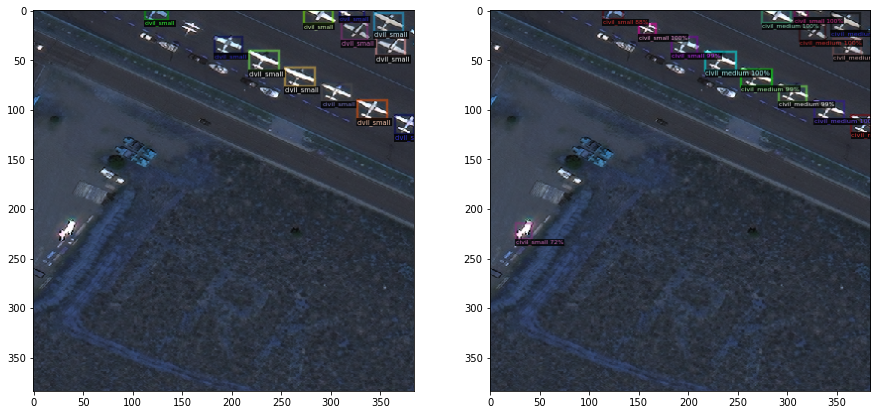

In [36]:
# Ground truth image
img = cv2.imread(civil_role_real_test_images_path + file_chosen + '.png')
visualizer = Visualizer(img[:, :, ::-1], metadata=satrgb_metadata, scale=0.75)

# # fine ann for file_chosem
d = [d for d in test_dicts if d['file_name'].split('.')[0].split('/')[-1] == file_chosen][0]
d_tmp = copy.deepcopy(d)
del d_tmp['annotations'][0]['segmentation'] # so do not draw mask
print(d['file_name'])
vis = visualizer.draw_dataset_dict(d_tmp)
test_image = vis.get_image()[:, :, ::-1]
test_arr = np.zeros(test_image.shape,np.uint8)
test_arr[:,:,:] = test_image[:,:,:]
test_img = Image.fromarray(test_arr)
test_img.save(f'{file_chosen}_test.eps')

# Inference image
outputs = predictor(img)
v = Visualizer(img[:, :, ::-1], metadata=satrgb_metadata, scale=0.75, instance_mode=ColorMode.IMAGE_BW)   # remove the colors of unsegmented pixels
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
inf_image = v.get_image()[:, :, ::-1]
inf_arr = np.zeros(inf_image.shape,np.uint8)
inf_arr[:,:,:] = inf_image[:,:,:]
inf_img = Image.fromarray(inf_arr)
inf_img.save(f'{file_chosen}_inf.eps')

print("filename = " + file_chosen)

%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 15,10
# read images
# img_A = mpimg.imread(f'{file_chosen}_test.png')
# img_B = mpimg.imread(f'{file_chosen}_inf.png')
# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(test_img);
ax[1].imshow(inf_img);
plt.show()

## DTD

In [35]:
img = cv2.imread('/content/gdrive/MyDrive/cropped_civil_role_images_DTD/predicted_civil_small/81_1040010032B86F00_tile_373_1th.png_sample.png')
img = Image.fromarray(img)
img.save('81_1040010032B86F00_tile_373_1th_imagenet_dtd.eps')

In [ ]:
file_chosen

'81_1040010032B86F00_tile_373'

In [ ]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

# logger = logging.getLogger()
# logger.setLevel("INFO")
# formatter = logging.Formatter(
#     '%(asctime)s [%(levelname)s] %(message)s (%(filename)s:%(lineno)s)')
# stream_handler = logging.StreamHandler()
# stream_handler.setLevel("INFO")
# stream_handler.setFormatter(formatter)
# logger.addHandler(stream_handler)
# logging.info('data loading')

class_wise_dtd = True
resnet_model = resnet_model.to('cpu')
resnet_model.train(False)
module_list = sa_map.model_flattening(resnet_model)
act_store_model = sa_map.ActivationStoringNet(module_list)
my_DTD = ClassWiseDTD() if class_wise_dtd else sa_map.DTD()

print('testing with saliency mapping start')

testing with saliency mapping start


In [ ]:
# for each instance in file_chosen, will visualize DTD for all 3 classes
file_chosen_instances_prediction = prediction_dict_df[prediction_dict_df['instance_file_name'].str.startswith(file_chosen)]
file_chosen_instances_prediction.head()

,instance_file_name,bbox,category
6805,81_1040010032B86F00_tile_373_1th,"[127.2379150390625, 133.0315704345703, 161.795...",0
6806,81_1040010032B86F00_tile_373_2th,"[128.24713134765625, 132.7957000732422, 164.39...",1


In [ ]:
# note the category_id used in faster-cnn is different from the label used in DTD
# In faster-rcnn:
#                 0 -> small
#                 1 -> medium
#                 2 -> large
# In DTD
#                 1 -> large
#                 2 -> medium
#                 3 -> small
id2dir = {0: 'predicted_civil_small', 1:'predicted_civil_medium', 2: 'predicted_civil_large'}
dtd_id2dir = {0: 'civil_large', 1:'civil_medium', 2: 'civil_small'}
for _, instance in file_chosen_instances_prediction.iterrows():

    file_name = instance['instance_file_name']

    # create file and dir structures required for DTD
    src_path = f"/content/gdrive/MyDrive/cropped_civil_role_images/{id2dir[instance['category']]}/{file_name}.png"
    dst_path_for_civil_small = f"/content/gdrive/MyDrive/DTD_samples/{id2dir[instance['category']]}/{file_name}/civil_small/"
    dst_path_for_civil_medium = f"/content/gdrive/MyDrive/DTD_samples/{id2dir[instance['category']]}/{file_name}/civil_medium/"
    dst_path_for_civil_large = f"/content/gdrive/MyDrive/DTD_samples/{id2dir[instance['category']]}/{file_name}/civil_large/"

    if not os.path.exists(dst_path_for_civil_small):
        os.makedirs(dst_path_for_civil_small)
    if not os.path.exists(dst_path_for_civil_medium):
        os.makedirs(dst_path_for_civil_medium)
    if not os.path.exists(dst_path_for_civil_large):
        os.makedirs(dst_path_for_civil_large)

    if class_wise_dtd is True:
        copyfile(src_path, dst_path_for_civil_small + file_name + '_ctg=0.png')
        copyfile(src_path, dst_path_for_civil_medium + file_name + '_ctg=1.png')
        copyfile(src_path, dst_path_for_civil_large + file_name + '_ctg=2.png')

    else:
        if id2dir[instance['category']] == 'predicted_civil_small':
            copyfile(src_path, dst_path_for_civil_small + file_name + '_ctg=0.png')
        elif id2dir[instance['category']] == 'predicted_civil_medium':
            copyfile(src_path, dst_path_for_civil_medium + file_name + '_ctg=1.png')
        else:
            copyfile(src_path, dst_path_for_civil_large + file_name + '_ctg=2.png')

    # do DTD
    test_dir = f"/content/gdrive/MyDrive/DTD_samples/{id2dir[instance['category']]}/{file_name}"
    dtd_sample_dir = f"/content/gdrive/MyDrive/DTD_samples/{id2dir[instance['category']]}/{file_name}"
    batch_size = 1
    num_workers = 1
    heatmap_scale = 1000

    test_dataset = datasets.ImageFolder(
                                        test_dir,
                                        transforms.Compose([
                                            transforms.Resize(224),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                        ]))
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                              num_workers=num_workers, pin_memory=True, shuffle=False,
                              drop_last=False)
    
    if class_wise_dtd is True:
        instance_file_names = [file_name + '_ctg=2_dtd.png', file_name + '_ctg=1_dtd.png', file_name + '_ctg=0_dtd.png']
    else:
        instance_file_names = [f"{file_name}_ctg={instance['category']}_dtd.png"]

    instance_file_idx = 0

    with torch.no_grad():
        for i, (image, target) in enumerate(test_loader):

            heatmap_name = f"{instance_file_names[instance_file_idx]}"
            
            image = Variable(image).to('cpu')
            target = Variable(target).to('cpu')


            print(f"instance_file: {heatmap_name}")

            if class_wise_dtd is False:
                print(f"faster_rcnn predicted class : {dtd_id2dir[target.numpy()[0]]}")
            else:
                print(f"enforced class : {dtd_id2dir[target.numpy()[0]]}")

            module_stack, output = act_store_model(image)

            # print(f"ResNet50 predicted class : {dtd_id2dir[output.numpy().argmax()]}")

            civil_large_score = round(output.numpy()[0][0], 2)
            civil_medium_score = round(output.numpy()[0][1], 2)
            civil_small_score = round(output.numpy()[0][2], 2)
            
            print(f"classification scores from (finetuned) ResNet50 : civil_large {civil_large_score}, civil_medium {civil_medium_score}, civil_small {civil_small_score}\n")

            if i % 1 == 0:

                if class_wise_dtd is True:
                    saliency_map = my_DTD(module_stack, output, 3, "resnet", i)
                else:
                    saliency_map = my_DTD(module_stack, output, 3, "resnet")
                
                saliency_map = torch.sum(saliency_map, dim=1)
                saliency_map_sample = saliency_map[0].detach().numpy()
                saliency_map_sample = np.maximum(0, saliency_map_sample)*255*heatmap_scale
                saliency_map_sample = np.minimum(255, saliency_map_sample)
                saliency_map_sample = np.uint8(saliency_map_sample)
                saliency_heatmap = cv2.applyColorMap(saliency_map_sample, cv2.COLORMAP_BONE)

                assert os.path.exists(dtd_sample_dir)
                
                heatmap_name = f"{instance_file_names[instance_file_idx]}"
                cv2.imwrite(os.path.join(dtd_sample_dir, heatmap_name), saliency_heatmap)
                sample_origin = image.cpu().data[0]

                instance_file_idx += 1

print(f"DTD done on all instances for {file_chosen} across civil role classes = {'all' if class_wise_dtd else id2dir[instance['category']]}!")

instance_file: 81_1040010032B86F00_tile_373_1th_ctg=2_dtd.png
enforced class : civil_large
classification scores from (finetuned) ResNet50 : civil_large 38.31999969482422, civil_medium 43.25, civil_small 44.86000061035156

tensor([[38.3231, 43.2498, 44.8596]])
tensor([38.3231,  0.0000,  0.0000])
instance_file: 81_1040010032B86F00_tile_373_1th_ctg=1_dtd.png
enforced class : civil_medium
classification scores from (finetuned) ResNet50 : civil_large 38.31999969482422, civil_medium 43.25, civil_small 44.86000061035156

tensor([[38.3231, 43.2498, 44.8596]])
tensor([ 0.0000, 43.2498,  0.0000])
instance_file: 81_1040010032B86F00_tile_373_1th_ctg=0_dtd.png
enforced class : civil_small
classification scores from (finetuned) ResNet50 : civil_large 38.31999969482422, civil_medium 43.25, civil_small 44.86000061035156

tensor([[38.3231, 43.2498, 44.8596]])
tensor([ 0.0000,  0.0000, 44.8596])
instance_file: 81_1040010032B86F00_tile_373_2th_ctg=2_dtd.png
enforced class : civil_large
classification sc

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

scores = [41.40999984741211, 39.45000076293945, 35.209999084472656]
print(softmax(scores))

[0.87497639 0.12324791 0.0017757 ]


In [ ]:
torch.zeros(3)

tensor([0., 0., 0.])